# 모듈 불러오기

In [1]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [5]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 모델 하이퍼파라미터 정의

In [6]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 30
VALIDATION_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index], 
         'rate': 0.1}

# 모델 선언 및 컴파일

## 패딩 및 포워드 마스킹

In [7]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [8]:
def create_look_ahead_mask(size):
    # linalg.band_part 함수는 하삼각 행렬을 생성하는 함수입니다. ** 하삼각 행렬: 기존 N x N 행렬을 삼각형 형태로 절반을 나눠서 하는 행렬
    # tf.ones((size, size))은 size x size 크기의 모든 요소가 1인 행렬을 생성합니다.
    # band_part의 두 번째 매개변수(-1)는 행렬의 하삼각 부분을 유지하라는 의미이고,
    # 세 번째 매개변수(0)는 상삼각 부분을 제거하라는 의미입니다.
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

    # mask를 반환합니다. 이 마스크는 seq_len x seq_len 크기의 행렬로, 
    # 상삼각 부분이 1로 채워져 있습니다.
    return mask  # (seq_len, seq_len)    

In [9]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [10]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

## 포지셔널 인코딩

In [11]:
def get_angles(pos, i, d_model):
    # np.power: 제곱 함수
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

In [12]:
def positional_encoding(position, d_model):
    # get_angles 함수를 호출하여 각 위치와 차원에 대한 각도를 계산합니다.
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 배열의 짝수 인덱스(2i) 위치에 대해 sin 함수를 적용합니다.
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1) 위치에 대해 cos 함수를 적용합니다.
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    # 차원을 확장하여 배치 차원을 추가합니다.
    # angle_rads의 원래 shape가 (64, 512)였다면, 이 코드를 실행한 후 pos_encoding의 shape는 (1, 64, 512)가 됩니다.
    pos_encoding = angle_rads[np.newaxis, ...]

    # 텐서플로우의 텐서로 변환하여 반환합니다.
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


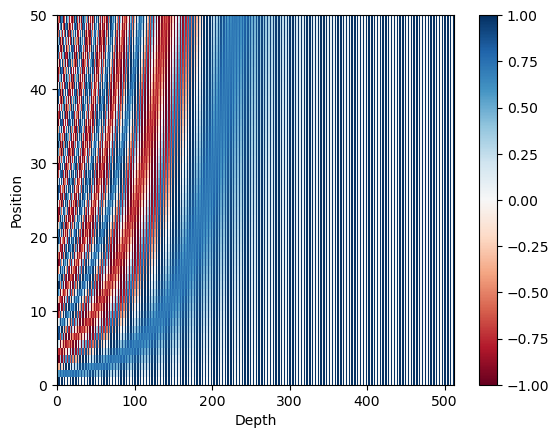

In [13]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

# plt.pcolormesh 함수는 2차원 배열의 값을 색상으로 표현하여 시각적으로 보여줍니다. 
# 이 그래프는 시퀀스의 각 위치와 모델의 각 차원(또는 깊이) 간의 관계를 색상으로 나타냅니다.
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 어텐션

In [14]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    # matmul : 행렬곱함수 (단 np.dot과는 다르다)
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## 멀티헤드 어텐션

In [15]:
# 어텐션은 개별적으로 실행되지만 멀티헤드 어텐션의 경우 병렬 처리를 위해 사용한다.
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']
        # assert는 이 조건이 참일때 코드는 내가 보장한다.
        # 이 조건은 올바르다!하지만 이 조건이 거짓이라는 것은 내가 보증하지 않은 동작이다. 그러니 AssertionError를 발생해라.
        # 라는 의미로 쓰이는 함수이다.
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        
        # transpose 함수가 하는 일은 입력 텐서 x의 차원을 주어진 순서에 맞게 재배열하는 것입니다.
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## 포인트 와이즈 피드포워드 네트워크

In [16]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(kargs['d_model'])  # (batch_size, seq_len, d_model)
    ])

## 인코더 레이어

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        # LayerNormalization : 정규화
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        
    def call(self, x, mask):
        #  mha (Multi-Head Attention):
        # 멀티헤드 어텐션은 트랜스포머 모델의 핵심 구성 요소 중 하나입니다. 
        # 입력 데이터에 대한 어텐션 매커니즘을 여러 개의 헤드(head)로 병렬로 적용하여, 서로 다른 표현 공간에서 입력 간의 관계를 파악할 수 있게 합니다.
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        # ffn (Feed-Forward Network):
        # 피드포워드 신경망은 트랜스포머 모델의 각 층에서 어텐션 이후에 적용되는 부분입니다. 
        # 이 신경망은 어텐션을 통해 추출된 특징을 더욱 깊이 있게 학습하기 위해 사용됩니다.
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

## 디코더 레이어

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## 인코더

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

## 디코더

In [20]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 트렌스포머 모델

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output
    
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)        
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens

## 모델 로스 정의

In [22]:
# 손실 함수로 Sparse Categorical Crossentropy를 사용하며,
# 이 함수는 정답 레이블이 one-hot 인코딩이 아닌 정수 형태로 주어질 때 사용
# from_logits=True는 로짓(logit) 출력이 주어질 때 사용하며,
# reduction="None"은 각 샘플별 손실을 반환함을 의미
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


# 학습 정확도를 측정하기 위해 Sparse Categorical Crossentropy 메트릭을 사용
# name='accuracy'는 이 메트릭의 이름을 'accuracy'로 지정
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

# 손실값을 계산하는 사용자 정의 함수
def loss(real, pred):
    # real 값이 0인 부분(보통 패딩된 부분)을 찾아내기 위한 마스크 생성
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 손실값 계산 (real: 실제값, pred: 예측값)
    loss_ = loss_object(real, pred)
    # 마스크를 loss와 같은 데이터 타입으로 변환
    mask = tf.cast(mask, dtype=loss_.dtype)
    # 마스크를 손실값에 곱하여, 마스크된 부분(패딩된 부분)은 손실값에서 제외
    loss_ *= mask
    # 전체 손실값의 평균을 계산하여 반환
    return tf.reduce_mean(loss_)    

# 정확도를 계산하는 사용자 정의 함수
def accuracy(real, pred):
    # real 값이 0인 부분(보통 패딩된 부분)을 찾아내기 위한 마스크 생성
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 마스크를 pred와 같은 데이터 타입으로 변환하고, 차원을 확장
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    # 마스크를 pred에 곱하여, 마스크된 부분(패딩된 부분)은 정확도 계산에서 제외
    pred *= mask    
    # 마스크된 부분을 제외한 정확도를 계산
    acc = train_accuracy(real, pred)
    # 전체 정확도의 평균을 계산하여 반환
    return tf.reduce_mean(acc)

In [23]:
model = Transformer(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
             loss= loss, metrics=[accuracy])

# Callback 선언

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, mode = 'max')
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/transformer.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/transformer -- Folder already exists 



# 모델 학습

In [34]:
history = model.fit([index_inputs, index_outputs], index_targets, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9721 - loss: 4.0268e-04
Epoch 1: val_accuracy improved from -inf to 0.97250, saving model to ./data_out/transformer/transformer.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9722 - loss: 3.9879e-04 - val_accuracy: 0.9725 - val_loss: 0.3268
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9728 - loss: 3.8464e-04
Epoch 2: val_accuracy improved from 0.97250 to 0.97309, saving model to ./data_out/transformer/transformer.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9728 - loss: 3.8097e-04 - val_accuracy: 0.9731 - val_loss: 0.3260
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9733 - loss: 3.6790e-04
Epoch 3: val_accuracy improved from 0.97309 to 0.97365, saving model to ./data_out/transformer/transformer.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9733 - loss: 3.6444e-04 - val_accuracy: 0.9736 - val_loss: 0.3253
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━

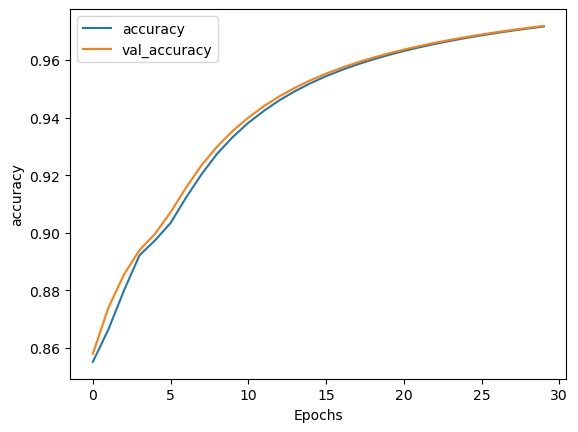

In [28]:
plot_graphs(history, 'accuracy')

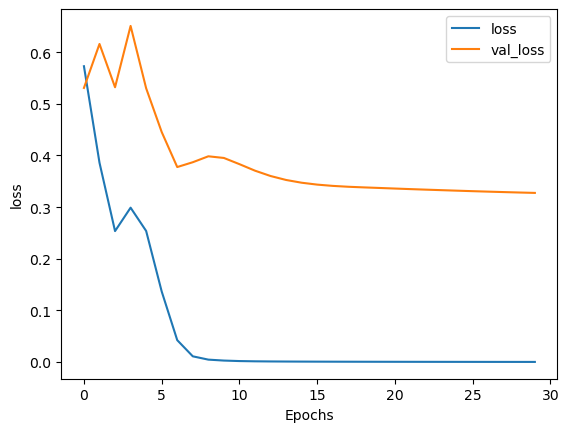

In [29]:
plot_graphs(history, 'loss')

# 베스트 모델 불러오기

In [38]:
# model.load_weights('./data_out/transformer/transformer.weights.h5')

In [39]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [48]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

평소에 필요했던 게 좋을 것 같아요
